## Images to Video

In [ ]:
import os
DATA_FOLDER = os.path.join(os.getcwd(), "data", "20221201-20:35:04")

In [ ]:
import os, cv2

CAMERA_FOLDER = os.path.join(DATA_FOLDER, "realsense_camera")
RECON_FOLDER = os.path.join(CAMERA_FOLDER, "reconstructed")
if not os.path.isdir(RECON_FOLDER): os.mkdir(RECON_FOLDER)

VIDEO_PATH = os.path.join(RECON_FOLDER, 'reconstructed_video.mp4')
result = cv2.VideoWriter(VIDEO_PATH, cv2.VideoWriter_fourcc('m','p','4','v'), 50, [640, 480])

idx = 0
IMAGE_PATH = os.path.join(RECON_FOLDER, str(idx) + '.jpg')

while os.path.isfile(IMAGE_PATH):
    img = cv2.imread(IMAGE_PATH)
    result.write(img)

    idx += 1
    IMAGE_PATH = os.path.join(RECON_FOLDER, str(idx) + '.jpg')

result.release()
cv2.destroyAllWindows()
print(idx)


## Video to Images

In [ ]:
import os
DATA_FOLDER = os.path.join(os.getcwd(), "data", "20221201-20:35:04")

In [ ]:
import os, cv2

CAMERA_FOLDER = os.path.join(DATA_FOLDER, "realsense_camera")
RECON_FOLDER = os.path.join(CAMERA_FOLDER, "reconstructed")
if not os.path.isdir(RECON_FOLDER): os.mkdir(RECON_FOLDER)

VIDEO_PATH = os.path.join(CAMERA_FOLDER, 'rs.mp4')
# VIDEO_PATH = os.path.join(CAMERA_FOLDER, 'true_video.mp4')
video_reader = cv2.VideoCapture(VIDEO_PATH)

idx = 0

while True:
    ret, frame = video_reader.read()
    if frame is None:
        break

    IMAGE_PATH = os.path.join(RECON_FOLDER, str(idx) + '.jpg')
    cv2.imwrite(IMAGE_PATH, frame)

    idx += 1

video_reader.release()
cv2.destroyAllWindows()
print(idx)

## Global position + yaw (TPS)

In [26]:
import os
import numpy as np
DATA_FOLDER = os.path.join(os.getcwd(), "data", "20221201-20:35:04")

In [ ]:
import os, cv2, apriltag, math
from utils.utils_tps import tps_trans

tps_coef = np.load(os.path.join(DATA_FOLDER, "tps_coef.npy"))

CAMERA_FOLDER = os.path.join(DATA_FOLDER, "realsense_camera")
VIDEO_PATH = os.path.join(CAMERA_FOLDER, 'rs.mp4')
video_reader = cv2.VideoCapture(VIDEO_PATH)

rs_pos_data = np.empty(shape=(0,2))
rs_yaw_data = []

x = np.linspace(170,470,4)
y = np.linspace(90,390,4)
X, Y = np.meshgrid(x,y)
ctrl_xy = np.stack([X,Y],axis=2).reshape(-1,2)
real_center_pos = np.zeros([1,2])

while True:
    ret, frame = video_reader.read()
    if frame is None:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    options = apriltag.DetectorOptions(families="tag36h11")
    detector = apriltag.Detector(options)
    results = detector.detect(gray)

    for r in results:
        (ptA, ptB, ptC, ptD) = r.corners
        ptB = (int(ptB[0]), int(ptB[1]))
        ptC = (int(ptC[0]), int(ptC[1]))
        ptD = (int(ptD[0]), int(ptD[1]))
        ptA = (int(ptA[0]), int(ptA[1]))

        (cX, cY) = (int(r.center[0]), int(r.center[1]))
        center_pos = np.array([[cX, cY]])
        real_center_pos = tps_trans(center_pos, ctrl_xy, tps_coef)

        tany = abs((ptC[1]+ptD[1])/2 - cY)
        tanx = (ptC[0]+ptD[0])/2 - cX
        rad = math.atan2(tanx, tany)
        deg = int(rad * 180 / math.pi)

        rs_pos_data = np.append(rs_pos_data, np.array([[real_center_pos[0, 1], -real_center_pos[0, 0]]]), axis=0)
        rs_yaw_data.append(rad)

np.save(os.path.join(DATA_FOLDER, "rs_pos.npy"), rs_pos_data)
np.save(os.path.join(DATA_FOLDER, "rs_yaw.npy"), rs_yaw_data)

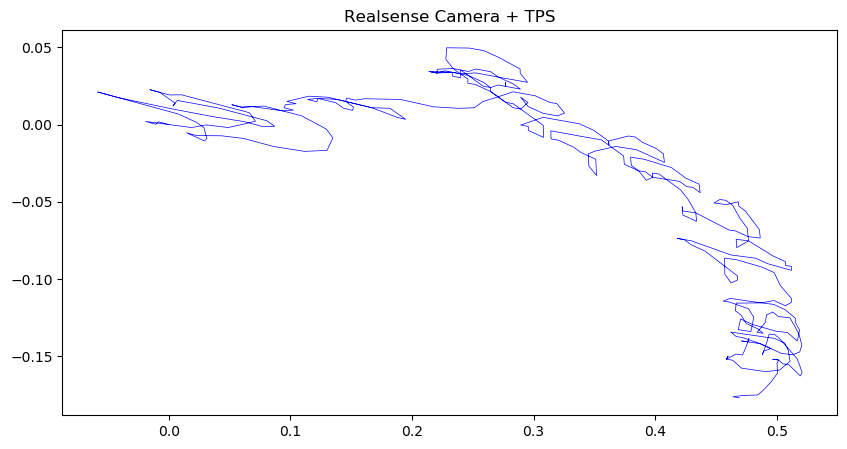

(502, 2)


In [2]:
# Plot Global Position
import matplotlib.pyplot as plt
rs_pos_data = np.load(os.path.join(DATA_FOLDER, "rs_pos.npy"))
rs_yaw_data = np.load(os.path.join(DATA_FOLDER, "rs_yaw.npy"))

rs_pos_data = rs_pos_data - rs_pos_data[0,:]

fig = plt.figure(figsize=(10, 5))
plt.plot(rs_pos_data[:,0], rs_pos_data[:,1], c='b',linewidth=0.5)
plt.title("Realsense Camera + TPS")
plt.show(block=False)

print(rs_pos_data.shape)

## Velocity

In [27]:
import os
import numpy as np
DATA_FOLDER = os.path.join(os.getcwd(), "data", "20221201-20:35:04")

In [ ]:
# Position -> Velocity
time = 1/50
rs_pos_data = np.load(os.path.join(DATA_FOLDER, "rs_pos.npy"))
rs_vel_data = np.zeros([rs_pos_data.shape[0]-1, 2])

for i in range(rs_vel_data.shape[0]):
    rs_vel_data[i,0] = (rs_pos_data[i+1,0] - rs_pos_data[i,0]) / time
    rs_vel_data[i,1] = (rs_pos_data[i+1,1] - rs_pos_data[i,1]) / time

np.save(os.path.join(DATA_FOLDER, "rs_vel.npy"), rs_vel_data)
print(rs_vel_data.shape)

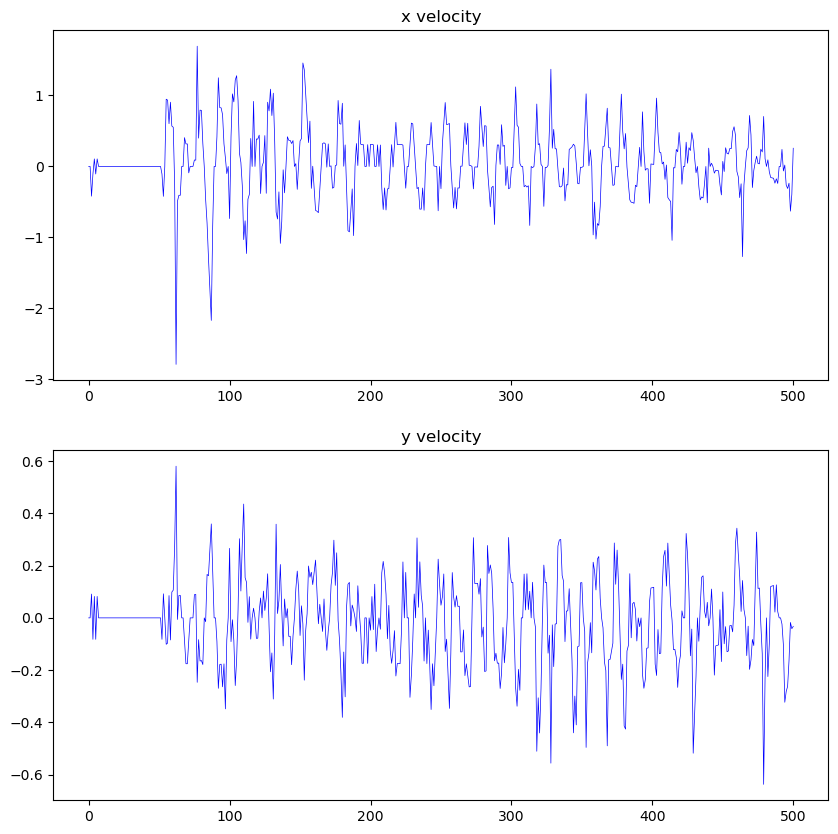

In [6]:
rs_vel_data = np.load(os.path.join(DATA_FOLDER, "rs_vel.npy"))
# print(rs_vel_data[:500])

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(rs_vel_data[:,0], c='b',linewidth=0.5)
plt.title("x velocity")

plt.subplot(2, 1, 2)
plt.plot(rs_vel_data[:,1], c='b',linewidth=0.5)
plt.title("y velocity")

plt.show(block=False)


<function matplotlib.pyplot.show(*args, **kw)>

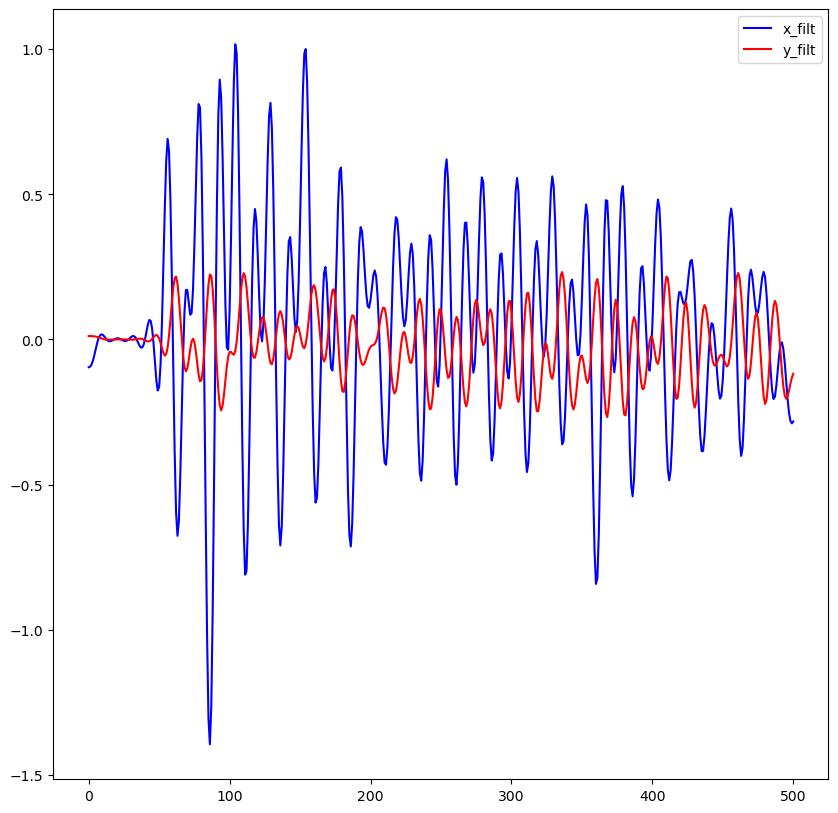

In [22]:
from scipy import signal

x_vel = rs_vel_data[:,0]
y_vel = rs_vel_data[:,1]

b, a = signal.ellip(4, 0.01, 120, 0.125)

x_filt = signal.filtfilt(b, a, x_vel, method="gust")
y_filt = signal.filtfilt(b, a, y_vel, method="gust")

fig = plt.figure(figsize=(10,10))
# plt.plot(x_vel, 'k-', label='x)
plt.plot(x_filt, 'b-', label='x_filt')
plt.plot(y_filt, 'r-', label='y_filt')
plt.legend(loc='best')
plt.show

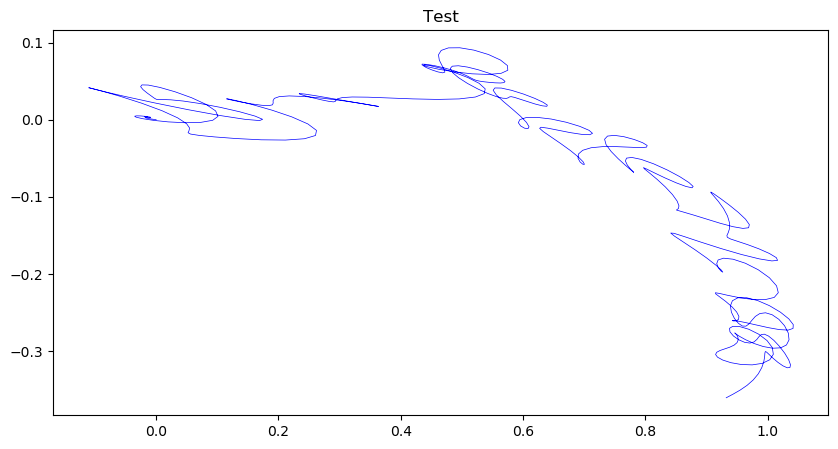

In [28]:
rs_vel_filt = np.zeros([len(x_filt), 2])
rs_vel_filt[:,0] = x_filt
rs_vel_filt[:,1] = y_filt

Hz = 25
predicted_test_data = np.zeros([rs_vel_filt.shape[0]+1, 2])

for i in range(rs_vel_filt.shape[0]):
    predicted_test_data[i+1,0] = predicted_test_data[i,0] + rs_vel_filt[i,0] * 1/Hz
    predicted_test_data[i+1,1] = predicted_test_data[i,1] + rs_vel_filt[i,1] * 1/Hz

fig = plt.figure(figsize=(10, 5))
plt.plot(predicted_test_data[:,0], predicted_test_data[:,1], c='b',linewidth=0.5)
plt.title("Test")
plt.show(block=False)

np.save(os.path.join(DATA_FOLDER, "rs_vel_filt.npy"), rs_vel_filt)
